this notebook was used to create a standartized inventory for pico, including the spiketimes and psth h5 files. additionally, the information at hand was extracted from the excel file and saved.

In [1]:
import numpy as np
import io
import pandas as pd
import os
import fnmatch
import shutil
import re
from ruamel.yaml import YAML


In [2]:
def find_directories_with_name(root_dir, directory_name):
    directory_paths = []
    for foldername, subfolders, _ in os.walk(root_dir):
        # print(foldername, subfolders, _)
        if directory_name in subfolders:
            added = True
            for subsubfolder in os.listdir(os.path.join(foldername, directory_name)):
                if os.path.isdir(os.path.join(foldername, directory_name, subsubfolder)):
                    directory_paths.append(os.path.join(foldername, directory_name, subsubfolder))
                else: added = False
            if added == False: directory_paths.append(os.path.join(foldername, directory_name))

    return directory_paths

def find_files_with_extension(root_dir, extension):
    file_paths = []
    for foldername, subfolders, filenames in os.walk(root_dir):
        for filename in fnmatch.filter(filenames, f'*.{extension}'):
            file_paths.append(os.path.join(foldername, filename))
    return file_paths

def get_date(date):
    """
    Get the Dates from the Excel file.
    """

    try:
        dates = date.split('/')
        if len(dates[-1])>2:year = dates[-1]
        else: year=f'20{dates[-1]}'
        if len(dates[0])>1: month = dates[0]
        else: month = f'0{dates[0]}'
        if len(dates[1])>1:day=dates[1]
        else:day=f'0{dates[1]}'
        

    except:
        try:
            dates = str(date).split()[0].split('-')
            if len(dates)==3:
                year=dates[0]
                month=dates[1]
                if len(dates[2])>1:day=dates[2]
                else:day=f'0{dates[2]}'
            else:
                pass
        except:
            pass

    try: return day, month, year
    except: return 0,0,0
    
def find_files_with_pattern(root_dir, pattern):
    """
    Find Associated .h5 File for each SpikeTime Folder.
    """
    return [os.path.join(foldername, filename) for foldername, subfolders, filenames in os.walk(root_dir) for filename in filenames if filename.startswith(pattern) and filename.endswith('.h5')]


In [10]:
############### Find Directories of SpikeTimes ################################
###############################################################################

parent_directory = '/braintree/data2/active/users/sgouldin/projects'
target_directory_name = 'spikeTime'
spikeTime_directories = find_directories_with_name(parent_directory, target_directory_name)
# print(len(spikeTime_directories))

spike_parent = []
for path in spikeTime_directories:
    try: 
        if path.split('/')[9] == 'pico':
            spike_parent.append(os.path.join(*path.split('/')[0:-1]))
    except: pass
    #spike_parent.append(os.path.join(*path.split('/')[0:10]))

############### Find Directories of psth ######################################
###############################################################################

psth_directories = find_directories_with_name(parent_directory, 'psth')
psth_parent = []
for path in psth_directories:
    try: 
        if path.split('/')[9] == 'pico':
            psth_parent.append(os.path.join(*path.split('/')[0:-1]))
    except: pass
############### Find Directories of IntanRaw ##################################
###############################################################################

parent_directory = '/braintree/data2/active/users/sgouldin/projects'
target_directory_name = 'intanraw'
intanRaw_directories = find_directories_with_name(parent_directory, target_directory_name)
# print(len(intanRaw_directories))

intanRaw_parents = []
for path in intanRaw_directories:
    try: 
        if path.split('/')[9] == 'pico':
            intanRaw_parents.append(os.path.join(*path.split('/')[10]))
    except: pass #print(path)
    # intanRaw_parents.append(os.path.join(*path.split('/')[10]))


############### Find Directories for PSTH h5 Files ############################
###############################################################################
parent_directory = '/braintree/data2/active/users/sgouldin/projects'
extension = 'h5'
h5_directories = find_files_with_extension(parent_directory, extension)
# print(len(h5_directories))


In [13]:
set(spike_parent) - set(psth_parent)

{'braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanproc/pico_normalizers_230804_152622',
 'braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanproc/pico_normalizers_230808_132257',
 'braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanproc/pico_normalizers_230809_120658'}

In [62]:
############### Get Info for Pico Data ########################################
###############################################################################

intan_names = []
names = []
dates = []
times = []
pico_intanRaw_directories  = []

for path in intanRaw_directories:
    try:
        if path.split('/')[9] == 'pico': 
            try: 
                intan_names.append(path.split('/')[11])
                dates.append((path.split('/')[11].split('_')[-2]))
                times.append((path.split('/')[11].split('_')[-1]))
                names.append(path.split('/')[7])
                pico_intanRaw_directories.append(path)
            except: pass
    except: pass

spike_names = []
pico_spikeTime_directories = []
for path in spikeTime_directories:
    try:
        if path.split('/')[9] == 'pico':
            spike_names.append(path.split('/')[11])
            pico_spikeTime_directories.append(path)
    except: pass #print(path)


psth_names = []
pico_psth_directories = []
for path in psth_directories:
    try:
        if path.split('/')[9] == 'pico':
            for ele in os.listdir(os.path.join('/', *path.split('/')[0:-1])):
                if ele.endswith(".mat"): 
                    psth_names.append(path.split('/')[11])
                    path_ = os.path.join(os.path.join('/', *path.split('/')[0:-1], ele))
                    pico_psth_directories.append(path_)
    except: pass #print(path)


h5_names = []
h5_dates = []
pico_h5_directories = []
for path in h5_directories:
    try:
        if path.split('/')[9] == 'pico':
            h5_names.append(path.split('/')[7])
            h5_dates.append(path.split('/')[11].split('.')[0])
            pico_h5_directories.append(path)
    except: pass #print(path)

In [64]:
def get_date(date):
    """
    Get the Dates from the Excel file.
    """

    try:
        dates = date.split('/')
        if len(dates[-1])>2:year = dates[-1][2:]
        else: year=f'{dates[-1]}'
        if len(dates[0])>1: month = dates[0]
        else: month = f'0{dates[0]}'
        if len(dates[1])>1:day=dates[1]
        else:day=f'0{dates[1]}'
        

    except:
        try:
            dates = str(date).split()[0].split('-')
            if len(dates)==3:
                year=dates[0][2:]
                month=dates[1]
                if len(dates[2])>1:day=dates[2]
                else:day=f'0{dates[2]}'
            else:
                pass
        except:
            pass

    try: return day, month, year
    except: return 0,0,0

############### Create DataFrame ##############################################
###############################################################################

df = pd.DataFrame({'ImageSet': names})
df['date'] = dates
df['time'] = times
df['Has SpikeTime']     = [0]*len(pico_intanRaw_directories)
df['Has psth']     = [0]*len(pico_intanRaw_directories)
df['Has h5']            = [0]*len(pico_intanRaw_directories)
df['Has Excel']         = [0]*len(pico_intanRaw_directories)
df['(excel) Index']          = ['']*len(pico_intanRaw_directories)
df['(excel) Stimuli']          = ['']*len(pico_intanRaw_directories)
df['(excel) Num Reps']          = ['']*len(pico_intanRaw_directories)
df['(excel) Num Images']        = ['']*len(pico_intanRaw_directories)
df['(excel) Total Num Images']  = ['']*len(pico_intanRaw_directories)
df['(excel) Notes']  = ['']*len(pico_intanRaw_directories)
df['Path: SpikeTimes']  = ['']*len(pico_intanRaw_directories)
df['Path: psth']  = ['']*len(pico_intanRaw_directories)
df['Path: h5']          = ['']*len(pico_intanRaw_directories)
df['Path: intanraw']    =  pico_intanRaw_directories

indices_spiketime = [index for index, name in enumerate(intan_names) if name in spike_names]
for ind in indices_spiketime:
    df.at[ind, 'Has SpikeTime'] = 1
    df.at[ind, 'Path: SpikeTimes'] = pico_spikeTime_directories[spike_names.index(intan_names[ind])]

indices_psth = [index for index, name in enumerate(intan_names) if name in psth_names]
for ind in indices_psth:
    df.at[ind, 'Has psth'] = 1
    df.at[ind, 'Path: psth'] = pico_psth_directories[psth_names.index(intan_names[ind])]



i = 0
for path, date in zip(pico_intanRaw_directories, dates):
    matching_h5files = find_files_with_pattern(os.path.join('/', *path.split('/')[0:10]), date)
    if len(matching_h5files) == 1:
        df.at[i, 'Path: h5'] = matching_h5files[0]
        df.at[i, 'Has h5'] = 1
    if len(matching_h5files) > 1:
        df.at[i, 'Path: h5'] = f'{len(matching_h5files)} files: {matching_h5files}'
        df.at[i, 'Has h5'] = 1
    i += 1

############### Load Excel File ###############################################
###############################################################################
path = '/braintree/home/aliya277/dandi_brainscore/Pipeline Monkey Schedule New.xlsx'
data = pd.read_excel(path, sheet_name='pico')
new_header = data.iloc[0]  
data = data[1:]       
data.columns = new_header  
data = data.fillna('empty')  

def add_from_excel(df, data, index):
    df.at[ind, 'Has Excel']                 = 1
    df.at[ind, '(excel) Index']             = index+2
    df.at[ind, '(excel) Stimuli']           = data['Stimuli'][index]
    df.at[ind, '(excel) Num Reps']          = data['Reps'][index]
    df.at[ind, '(excel) Num Images']        = data['Images*/Videos'][index]
    df.at[ind, '(excel) Total Num Images']  = data['Total images/Videos'][index]
    df.at[ind, '(excel) Notes']  = data['Notes'][index]


for intan, ind in zip(pico_intanRaw_directories, range(len(pico_intanRaw_directories))):
    hasexcel = False

    ############### Get Recording Info from FileName ##############################
    ###############################################################################
    date = ((intan.split('/')[11].split('_')[-2]))
    time = ((intan.split('/')[11].split('_')[-1]))
    name = (intan.split('/')[7])
    found_item = False

    ############### Filter by Date in FileName and ExcelDate ##########################
    ###############################################################################
    for exl_date,index in zip(data['Date'], range(1,len(data))):
        exl_day, exl_month, exl_year = get_date(exl_date)
        
        if exl_year+exl_month+exl_day == date:

            ############### Filter by FileName and ExcelStimulus ##########################
            ###############################################################################
            list = [data['Stimuli'][index]]
            for i in range(1,10):
                try:
                    if data['Date'][index+i] == 'empty':
                        list.append(data['Stimuli'][index+i])
                        i+=1
                    else:
                        break
                except:break

            # check stim name
            for item, i in zip(list, range(len(list))): 
                if item.lower() in name:
                    add_from_excel(df, data, index+i)
                    found_item = True

            # check _ and -
            if found_item == False:
                for item, i in zip(list, range(len(list))):
                    name_new = name.lower().replace('-', '_').split('_')
                    item_new = item.lower().replace('-', '_').split('_') 

                    if set(item_new).intersection(set(name_new)) == set(item_new) or set(name_new).intersection(set(item_new)) == set(name_new):
                        add_from_excel(df, data, index+i)
                        found_item = True

            # manually correct rest
            if found_item == False:
                for item, i in zip(list, range(len(list))):
                    if name == 'monkeyvalence' and item.lower() in ['monkeyvalence2','monkeyvalence3', 'monkeyvalence4', \
                                                                    'monkeyvalence5', 'monkeyvalence6', 'monkeyvalence7', 'monkeyvalence8']:
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'shapegen' and intan.split('/')[-1].split('_')[2] == 'static' and item.lower() == 'shapegen - static':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'shapegen' and intan.split('/')[-1].split('_')[2] == 'dynamic' and item.lower() == 'shapegen - dynamic':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == '1_shapes' and item.lower() == 'shapenet images':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'normalizers-HVM' and item.lower() == 'normalizers - hvm':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'facescrub-small' and item.lower() == 'faces_transformation':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'object_relations' and item.lower() == 'object_relationships':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'RF_Mapping_Yoon' and item in ['RF-Yoon Pico version', 'RFMapping_Yoon', 'RF-Yoon Pico version']:
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'emogan' and item.lower() == 'emogen':
                        add_from_excel(df, data, index+i)
                        found_item = True
                    if name == 'IAPS' and intan.split('/')[-1].split('_')[2] == '200on' and item == 'IAPS - 200on':
                        add_from_excel(df, data, index+i)
                        found_item = True

    if found_item == False:
        print('No Excel: ', date, name, intan)
        
# display(df.tail(10))

############### Save New Excel File ###########################################
###############################################################################

excel_file_path = '/braintree/home/aliya277/dandi_brainscore/pico_inventory_new.xlsx'  
df.to_excel(excel_file_path, index=False) 


############### Add New Sheet to Excel File ###################################
###############################################################################

# Create a list to store the results
result_list = []

# Group the DataFrame by 'ImageSet' and iterate through the groups
for group, group_df in df.groupby('ImageSet'):
    image_set = group
    num_entries = len(group_df)
    num_has_excel = group_df['Has Excel'].astype(int).sum()
    num_has_spike_time = group_df['Has SpikeTime'].astype(int).sum()
    num_has_psth = group_df['Has psth'].astype(int).sum()
    num_has_h5 = group_df['Has h5'].astype(int).sum()
    
    # Append the results to the list
    result_list.append({
        'ImageSet': image_set,
        'Num Rec. Sess.': num_entries,
        'Num Has SpikeTime': num_has_spike_time,
        'Num Has psth': num_has_psth,
        'Num Has h5': num_has_h5,
        'Num Has Excel': num_has_excel,
        'BrainScore': '',
        'Comments': ''
    })

# Convert the list of dictionaries to a DataFrame
summary_df = pd.DataFrame(result_list)

# Optionally, set 'ImageSet' as the index
# summary_df.set_index('ImageSet', inplace=True)
summary_df = summary_df.sort_values(by='Num Rec. Sess.', ascending=False)
# Display the summary DataFrame
display(summary_df.head(5))


existing_excel_file = '/braintree/home/aliya277/dandi_brainscore/pico_inventory_new.xlsx' 

# Create a Pandas ExcelWriter object
with pd.ExcelWriter(existing_excel_file, engine='openpyxl', mode='a') as writer:
    # Write your DataFrame to a new sheet
    summary_df.to_excel(writer, sheet_name='Sheet2', index=False)  # 'Sheet2' is the name of the new sheet


No Excel:  220719 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_220719_140828
No Excel:  230922 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_230922_134247
No Excel:  230929 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_230929_095756
No Excel:  230106 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_230106_162941
No Excel:  230920 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_230920_111320
No Excel:  230925 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_230925_111712
No Excel:  230927 normalizers /braintree/data2/active/users/sgouldin/projects/normalizers/monkeys/pico/intanraw/pico_normalizers_230927_100801

,ImageSet,Num Rec. Sess.,Num Has SpikeTime,Num Has psth,Num Has h5,Num Has Excel,BrainScore,Comments
41,normalizers,168,104,101,89,160,,
42,normalizers-HVM,31,3,3,3,31,,
36,monkeyvalence,17,0,0,0,17,,
34,mayo,14,14,14,10,14,,
38,muri1320,12,12,0,0,12,,


In [61]:
############### Create Directories ############################################
###############################################################################

df = pd.read_excel( '/braintree/home/aliya277/dandi_brainscore/pico_inventory_new.xlsx'  )
SubjectName = 'pico'
storage_dir = '/braintree/home/aliya277/inventory_new'
storage_old = '/braintree/home/aliya277/inventory'


def same_folders(dcmp):
    if dcmp.diff_files or dcmp.left_only or dcmp.right_only:
        return False
    for sub_dcmp in dcmp.subdirs.values():
        if not same_folders(sub_dcmp):
            return False
    return True

i = 0
print("Total: 223 Files")
for imageset, excelname, date_, time_, hasspike, haspsth, hash5, spikepath, psthpath, h5path in zip(df['ImageSet'], df['(excel) Stimuli'], df['date'], df['time'], df['Has SpikeTime'], \
    df['Has psth'], df['Has h5'], df['Path: SpikeTimes'], df['Path: psth'], df['Path: h5']):
    date = f'20{date_}'
    if len(str(time_)) != 6: time = f'0{time_}'
    else: time = time_
    if hasspike == 1:
        # check if directory in created inventory exists
        if imageset == 'normalizers':
            directory = f'norm_FOSS.sub_{SubjectName}.{date}_{time}.proc'
        elif imageset == 'normalizers-HVM':
            directory = f'norm_HVM.sub_{SubjectName}.{date}_{time}.proc'
        else: 
            directory = f'exp_{imageset}.sub_{SubjectName}.{date}_{time}.proc'
            directory_excel = f'exp_{excelname}.sub_{SubjectName}.{date}_{time}.proc'
        
        imagesetdir = os.path.join(storage_dir, ".".join(directory.split(".")[0:1]))
        subjectdir  = os.path.join(imagesetdir, ".".join(directory.split(".")[0:2]))
        subjectdir_date  = os.path.join(subjectdir, ".".join(directory.split(".")[0:2])+'.'+date)

        # Create a New Invetory.

        try: os.mkdir(imagesetdir)
        except: pass
        try: os.mkdir(subjectdir)
        except: pass
        try: os.mkdir(subjectdir_date, directory)
        except: pass

        print(f'{i} Copying SpikeTimes for {directory}')
        
        shutil.copytree(spikepath, os.path.join(subjectdir_date, directory, 'SpikeTimes'))
        
        if haspsth == 1: 

            # shutil.copy2(psthpath, subjectdir_date+'/'+directory+'/'+'psth')
            for ele in os.listdir(os.path.join('/', *psthpath.split('/')[0:-1])):
                if ele.endswith(".mat"): 
                    path = os.path.join(os.path.join('/', *psthpath.split('/')[0:-1], ele))
                    os.mkdir(subjectdir_date+'/'+directory+'/'+'psth')
                    print(f'Copying psth')
                    shutil.copy2(path, subjectdir_date+'/'+directory+'/'+'psth')

        if hash5 ==1:
            try: 
                os.mkdir( os.path.join(subjectdir_date, 'h5'))
                print(f'Copying h5')
                shutil.copy2(h5path, os.path.join(subjectdir_date, 'h5'))
            except: print('File already exists. ', directory)
        
        i += 1
        


Total: 223 Files
0 Copying SpikeTimes for norm_FOSS.sub_pico.20220616_111545.proc
Copying psth
Copying h5
1 Copying SpikeTimes for norm_FOSS.sub_pico.20220615_113442.proc
Copying psth
Copying h5
2 Copying SpikeTimes for norm_FOSS.sub_pico.20220907_142157.proc
Copying psth
Copying h5
3 Copying SpikeTimes for norm_FOSS.sub_pico.20220929_170635.proc
Copying psth
Copying h5
4 Copying SpikeTimes for norm_FOSS.sub_pico.20230216_145353.proc
Copying psth
5 Copying SpikeTimes for norm_FOSS.sub_pico.20230221_124922.proc
Copying psth
6 Copying SpikeTimes for norm_FOSS.sub_pico.20230224_142014.proc
Copying psth
7 Copying SpikeTimes for norm_FOSS.sub_pico.20230303_152601.proc
Copying psth
8 Copying SpikeTimes for norm_FOSS.sub_pico.20230328_145456.proc
Copying psth
Copying h5
9 Copying SpikeTimes for norm_FOSS.sub_pico.20230428_111937.proc
Copying psth
Copying h5
10 Copying SpikeTimes for norm_FOSS.sub_pico.20230508_120630.proc
Copying psth
Copying h5
11 Copying SpikeTimes for norm_FOSS.sub_pico.20

# old

In [27]:
############### Check Directories #############################################
###############################################################################

df = pd.read_excel( '/braintree/home/aliya277/dandi_brainscore/pico_inventory_new.xlsx'  )
SubjectName = 'pico'
storage_dir = '/braintree/home/aliya277/inventory'

def same_folders(dcmp):
    if dcmp.diff_files or dcmp.left_only or dcmp.right_only:
        return False
    for sub_dcmp in dcmp.subdirs.values():
        if not same_folders(sub_dcmp):
            return False
    return True



for imageset, excelname, date_, time_, hasspike, haspsth, hash5, spikepath, psthpath, h5path in zip(df['ImageSet'], df['(excel) Stimuli'], df['date'], df['time'], df['Has SpikeTime'], \
    df['Has psth'], df['Has h5'], df['Path: SpikeTimes'], df['Path: psth'], df['Path: h5']):
    date = f'20{date_}'
    if len(str(time)) != 6: time = f'0{time_}'
    else: time = time_
    if hasspike == 1:
        # check if directory in created inventory exists
        if imageset == 'normalizers':
            directory = f'norm_FOSS.sub_{SubjectName}.{date}_{time}.proc'
        elif imageset == 'normalizers-HVM':
            directory = f'norm_HVM.sub_{SubjectName}.{date}_{time}.proc'
        else: 
            directory = f'exp_{imageset}.sub_{SubjectName}.{date}_{time}.proc'
            directory_excel = f'exp_{excelname}.sub_{SubjectName}.{date}_{time}.proc'
        
        imagesetdir = os.path.join(storage_dir, ".".join(directory.split(".")[0:1]))
        subjectdir  = os.path.join(storage_dir, imagesetdir, ".".join(directory.split(".")[0:2]))
        subjectdir_date  = os.path.join(storage_dir, imagesetdir, ".".join(directory.split(".")[0:2])+'.'+date)
        print(imagesetdir)
        print(subjectdir)
        print(subjectdir_date)
            
        try: os.mkdir(imagesetdir)
        except: pass
        try: os.mkdir(subjectdir)
        except: pass
        try: os.mkdir(subjectdir_date)
        except: pass
        
        if os.path.isdir(subjectdir+'/'+directory): 
            #Check if has h5
            if hash5 == 1:
                try:os.mkdir(subjectdir+'/'+directory+'/'+'h5Files')
                except:pass
                if len(os.listdir(subjectdir+'/'+directory+'/'+'h5Files'))==0: 
                    print(f'Copy h5 files for {directory}')
            
            # Check if has SpikeTimes
            if len(os.listdir(subjectdir+'/'+directory+'/'+'SpikeTimes'))==0: 
                print(f'Copy SpikeTimes files for {directory}')

            # Check if has psth
            if haspsth == 1:
                # if os.path.isdir(os.listdir(subjectdir+'/'+directory+'/'+'psth')):
                    # if len(os.listdir(subjectdir+'/'+directory+'/'+'psth'))==0: 
                print(f'Copy psth files for {directory}')

            # check if has nwb file
            if any(fname.endswith('.nwb') for fname in os.listdir(subjectdir+'/'+directory)):
                for fname in os.listdir(subjectdir+'/'+directory): 
                    if fname.endswith('.nwb'): assert fname == directory+'.nwb', "Check NWB file name."
            else: print(f'Create NWB file for File {directory}')
                    
        # else: 
        #     ############### Copy Files in Respective Inventory Directory ##################
        #     ###############################################################################
        #     print(f'Copying Files for {directory}')
        #     shutil.copytree(spikepath, os.path.join(subjectdir, directory, 'SpikeTimes'))
        #     if hash5 == 1: 
        #         os.mkdir(os.path.join(subjectdir, directory, 'h5Files'))
                
        #         try: shutil.copy2(h5path, os.path.join(subjectdir, directory, 'h5Files', h5path.split('/')[-1]))
        #         except: print(h5path.split("[")[-1].split("]")[0][0])
        

# df['Path: SpikeTimes'][1]


/braintree/home/aliya277/inventory/norm_FOSS
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico.20220616
Copy psth files for norm_FOSS.sub_pico.20220616_111545.proc
/braintree/home/aliya277/inventory/norm_FOSS
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico.20220615
Copy psth files for norm_FOSS.sub_pico.20220615_113442.proc
/braintree/home/aliya277/inventory/norm_FOSS
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico.20220907
Copy psth files for norm_FOSS.sub_pico.20220907_142157.proc
/braintree/home/aliya277/inventory/norm_FOSS
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico
/braintree/home/aliya277/inventory/norm_FOSS/norm_FOSS.sub_pico.20220929
Copy psth files for norm_FOSS.sub_pico.20220929_170635.proc
/braintree/home/aliya277/invento

/tmp/ipykernel_30400/2224698501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['(excel) Num Reps'][242] = 1.3
/tmp/ipykernel_30400/2224698501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['(excel) Num Reps'][10] = 14


[  0.    1.    1.3   2.    3.    4.    5.    6.    7.    8.    9.   10.
  12.   13.   14.   15.   17.   18.   20.   25.   30.   32.   35.   40.
  44.   50.   65.  100.  200.    nan]
[  3  19   1  45  19   2   1   3   7   8   4  18   3   4   2  10   2   3
 180   2  15   1   1   4   1  40   5   1   2  22]
[  0.    1.    1.3   2.    3.    4.    5.    6.    7.    8.    9.   10.
  12.   13.   14.   15.   17.   18.   20.   25.   30.   32.   35.   40.
  44.   50.   65.  100.  200.    nan]
[ 3 19  1 45 19  2  1  3  7  8  4 18  3  4  1  9  1  3  2  2 15  1  1  3
  1 31  5  1  2 14]
[  0.    1.    1.3   2.    3.    6.    8.    9.   10.   13.   15.   17.
  18.   20.   30.   35.   40.   50.   65.  100.  200.    nan]
[ 2 19  1 32 16  1  1  2  4  2  1  1  2  1  6  1  3  2  5  1  2 11]
[  1.   2.  10.  13.  18.  35.  40.  50.  65. 200.  nan]
[ 2 14  4  2  1  1  3  1  2  1  2]


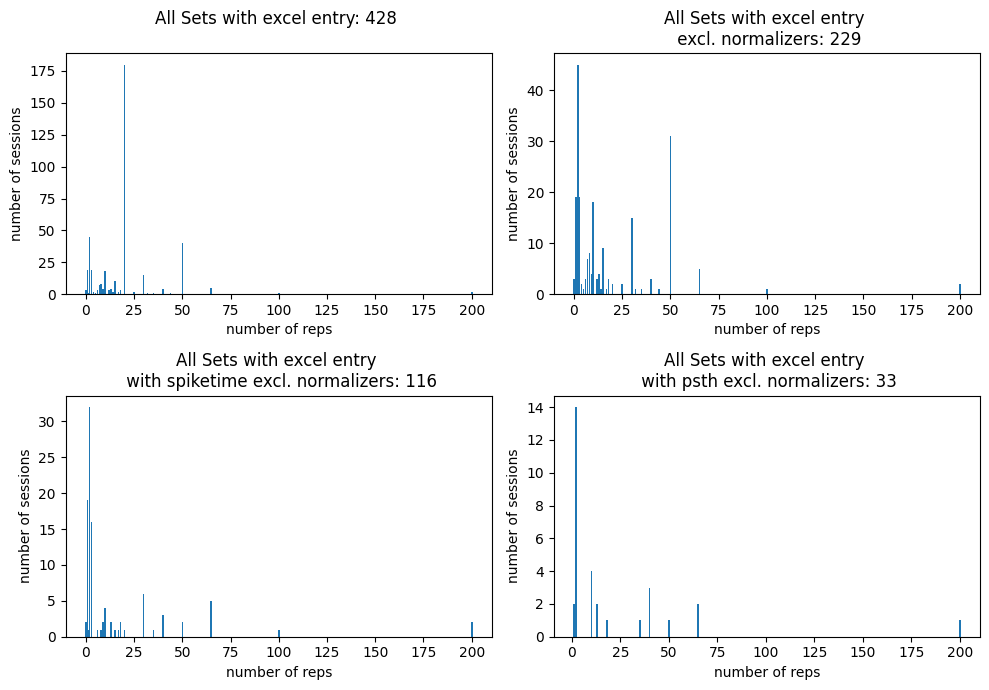

In [5]:
import numpy as np
import pandas as pd
df = pd.read_excel( '/braintree/home/aliya277/dandi_brainscore/pico_inventory.xlsx'  )
df['(excel) Num Reps'][242] = 1.3
df['(excel) Num Reps'][10] = 14

# number of reps in total
num_reps_total = []
for reps, spike in zip(df['(excel) Num Reps'].to_numpy(), df['Has SpikeTime'].to_numpy()):
    if type(reps) == int or type(reps)==float:
        num_reps_total.append(reps)


# number of reps excl. normalizers
num_reps_nonorm = []
for reps, image_set in zip(df['(excel) Num Reps'].to_numpy(), df['ImageSet'].to_numpy()):
    if (type(reps) == int or type(reps)==float)  and image_set != 'normalizers' and image_set != 'normalizers-HVM':
        num_reps_nonorm.append(reps)

# number of reps excl. normalizers and if exist spike time 
num_reps_nonorm_withspike = []
for reps, spike, image_set in zip(df['(excel) Num Reps'].to_numpy(), df['Has SpikeTime'].to_numpy(),df['ImageSet'].to_numpy()):
    if (type(reps) == int or type(reps)==float) and image_set != 'normalizers' and image_set != 'normalizers-HVM' and spike != 0:
        num_reps_nonorm_withspike.append(reps)

# number of reps excl. normalizers and if exist h5
num_reps_nonorm_withh5 = []
for reps, h5, image_set in zip(df['(excel) Num Reps'].to_numpy(), df['Has h5'].to_numpy(),df['ImageSet'].to_numpy()):
    if (type(reps) == int or type(reps)==float) and image_set != 'normalizers' and image_set != 'normalizers-HVM' and h5 != 0:
        num_reps_nonorm_withh5.append(reps)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(10,7))
ax = ax.flatten()
x,h = np.unique(num_reps_total, return_counts=True)
print(x)
print(h)
ax[0].bar(x,h)
ax[0].set_title(f"All Sets with excel entry: {len(num_reps_total)} \n")
ax[0].set_xlabel("number of reps")
ax[0].set_ylabel("number of sessions")
# ax[0].set_xlim(0, 70)

x, h = np.unique(num_reps_nonorm, return_counts=True)
print(x)
print(h)
ax[1].bar(x, h)
ax[1].set_title(f"All Sets with excel entry \n excl. normalizers: {len(num_reps_nonorm)}")
ax[1].set_xlabel("number of reps")
ax[1].set_ylabel("number of sessions")
# ax[1].set_xlim(0, 70)

x, h = np.unique(num_reps_nonorm_withspike, return_counts=True)
print(x)
print(h)
ax[2].bar(x, h)
ax[2].set_title(f"All Sets with excel entry \n with spiketime excl. normalizers: {len(num_reps_nonorm_withspike)}")
ax[2].set_xlabel("number of reps")
ax[2].set_ylabel("number of sessions")
# ax[2].set_xlim(0, 70)

x, h = np.unique(num_reps_nonorm_withh5, return_counts=True)
print(x)
print(h)
ax[3].bar(x, h)
ax[3].set_title(f"All Sets with excel entry \n with psth excl. normalizers: {len(num_reps_nonorm_withh5)}")
ax[3].set_xlabel("number of reps")
ax[3].set_ylabel("number of sessions")
# ax[3].set_xlim(0, 70)

plt.tight_layout()

In [5]:
############### Create Storage Dir and Load Excel File ########################
###############################################################################
   
storage_dir = '/braintree/home/aliya277/inventory'
try: os.mkdir(storage_dir)
except: pass
os.chdir('/braintree/home/aliya277')
path = 'dandi_brainscore/Pipeline Monkey Schedule New.xlsx'
data = pd.read_excel(path, sheet_name='pico')
new_header = data.iloc[0]  
data = data[1:]       
data.columns = new_header  
data = data.fillna('empty')  


for spike in (spikeTime_directories):

    ############### Get Recording Info from FileName ##############################
    ###############################################################################
    ind = spike.split('/').index('intanproc')
    SubjectName     = spike.split('/')[ind-1]
    ImageSetName_v1 = spike.split('/')[ind-3]
    Date            = re.findall('..',spike.split('/')[ind+1].split('_')[-2])
    year            = f'20{Date[0]}'
    month           = Date[1]
    day             = Date[2]
    SessionTime     = spike.split('/')[ind+1].split('_')[-1]

    
    if SubjectName == 'pico':


        ############### Filter by Date in FileName and ExcelDate ##########################
        ###############################################################################
        for date,index in zip(data['Date'], range(1,len(data))):
            exl_day, exl_month, exl_year = get_date(date)

            if exl_day+exl_month+exl_year == day+month+year:


                ############### Filter by FileName and ExcelStimulus ##########################
                ###############################################################################
                list = [data['Stimuli'][index]]
                for i in range(1,10):
                    try:
                        if data['Date'][index+i] == 'empty':
                            list.append(data['Stimuli'][index+i])
                            i+=1
                        else:
                            break
                    except:break
                found_item = False

                for item, i in zip(list, range(len(list))): 
                    if item.lower() in ImageSetName_v1:
                        ImageSetName = data['Stimuli'][index+i]
                        # StimOnnOff   = data['ON/OFF (ms)'][index+i]
                        RecInfo      = data.iloc[[index+i-1]].to_dict('records')[0]
                        found_item = True

                if found_item == False:
                    for item, i in zip(list, range(len(list))):
                        spike_new = ImageSetName_v1.lower().replace('-', '_').split('_')
                        item_new = item.lower().replace('-', '_').split('_') 

                        if set(item_new).intersection(set(spike_new)) == set(item_new) or set(spike_new).intersection(set(item_new)) == set(spike_new):
                            ImageSetName = data['Stimuli'][index+i]
                            # StimOnnOff   = data['ON/OFF (ms)'][index+i]
                            RecInfo      = data.iloc[[index+i-1]].to_dict('records')[0]
                            found_item = True
                
                ############### Create Standartized Directory Name ############################
                ###############################################################################
                if found_item == True:
                    SessionDate = f'{year}{month}{day}'
                    if ImageSetName == 'Normalizers':
                        directory = f'norm_FOSS.sub_{SubjectName}.{SessionDate}_{SessionTime}.proc'
                    elif ImageSetName == 'Normalizers-HVM':
                        directory = f'norm_HVM.sub_{SubjectName}.{SessionDate}_{SessionTime}.proc'
                    else: 
                        directory = f'exp_{ImageSetName}.sub_{SubjectName}.{SessionDate}_{SessionTime}.proc'

                    try: os.mkdir(os.path.join(storage_dir, directory))
                    except: pass


                    ############### Copy Files in Respective Inventory Directory ##################
                    ###############################################################################
                    matching_h5files = find_files_with_pattern(os.path.join('/', *spike.split('/')[0:10]), f'{Date[0]}{Date[1]}{Date[2]}')
                    
                    # shutil.copytree(spike, os.path.join(storage_dir, directory, 'SpikeTimes'))
                    # if matching_h5files:
                    #     for files in matching_h5files:
                    #         try: os.mkdir(os.path.join(storage_dir, directory, 'h5Files'))
                    #         except: pass
                    #         shutil.copy2(files, os.path.join(storage_dir, directory, 'h5Files', files.split('/')[-1]))

                    ############### Create .txt File with Relevant Info for NWB ###################
                    ###############################################################################
                    
                    RecInfo['intanproc'] = spike
                    RecInfo['SessionDate'] = SessionDate
                    RecInfo['SessionTime'] = SessionTime
                    yaml = YAML()
                    with open(os.path.join(storage_dir, directory,"RecInfo.yaml"), 'w') as yamlfile:
                        yaml.dump((RecInfo), yamlfile)


                    
                else:
                    print('Wrong Names: ', month, day, year, list, '\t', spike.split('/')[ind-3], index)
                    pass
                    
